In [ ]:
#Imports
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from google.colab import drive
import seaborn as sns

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Path to glove embedding
embeddings_file = '/content/drive/My Drive/CAIS Project/glove.twitter.27B.50d.txt'

In [ ]:
#Load data
dataset = pd.read_csv('/content/drive/My Drive/CAIS Project/data.csv')
dataset.head()

,valence,author,tweet
0,0,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,scotthamilton,is upset that he can't update his Facebook by ...
2,0,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,ElleCTF,my whole body feels itchy and like its on fire
4,0,Karoli,"@nationwideclass no, it's not behaving at all...."


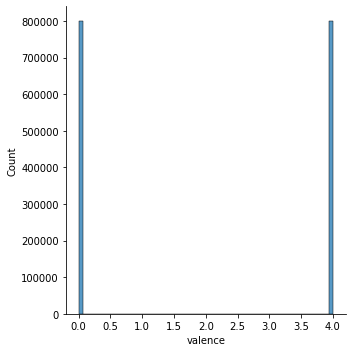

In [89]:
#Convert data from pandas to numpy
yValues = dataset['valence'].to_numpy()
yValues = np.reshape(yValues, (1600000,))
xValues = dataset['tweet'].to_numpy()
yValues = yValues.astype(int)

for i in range(len(yValues)):
  if (yValues[i] == 4):
    yValues[i] = 1

sns.displot(dataset['valence'])
#no "neutral" tweets -> can treat this as binary classification
#dataset is well-balanced: 50% split of +ve and -ve

In [ ]:
#Use embedding to process tweets
import os
embedding_dimension = 50
def preprocess_text(tweets, labels, embedding_address):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(tweets) 
  sequences = tokenizer.texts_to_sequences(tweets)
  word_index = tokenizer.word_index
  X_train = pad_sequences(sequences) 


  embeddings_index = {}
  f = open(embedding_address, 'rb')
  for line in f:
    values = line.split()
    word = values[0].decode('UTF-8')
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
  f.close()


  num_words = len(word_index)+1
  embedding_matrix = np.zeros((num_words, embedding_dimension))

  for word, i in word_index.items():
    if i >= num_words:
      continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

  return X_train, word_index, embedding_matrix

In [ ]:
#Generate word embeddings
xValues, word_index, embedding_matrix = preprocess_text(xValues, yValues, embeddings_file)

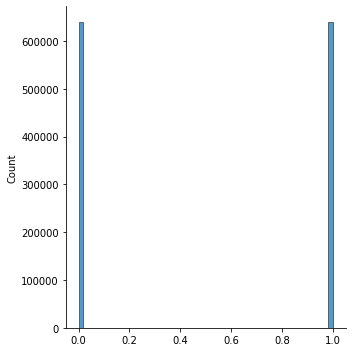

In [ ]:
#Split the data into train, test and val
from sklearn.model_selection import train_test_split

X_train, X_test_val, y_train, y_test_val = train_test_split(xValues, yValues, test_size=0.20, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.0032, random_state=42)
#Plot train set to ensure 50/50 split is retained
sns.displot(y_train)

#Model Training

In [ ]:
#Keras imports
from keras.models import Sequential
from keras.layers import Embedding, Input
from keras.layers.merge import Concatenate
from keras.layers.core import Dense, Activation, Flatten
from keras.layers import Dropout, concatenate
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import Bidirectional
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras import metrics
from keras.models import Model

In [ ]:
#Setup and compile model
model = Sequential()

model.add(Embedding(len(word_index) + 1,
                    embedding_dimension,
                    weights=[embedding_matrix],
                    input_length=X_train.shape[1],
                    trainable=False))

model.add(LSTM(64, return_sequences = True, activation='tanh'))
model.add(Dropout(.2))

model.add(LSTM(64, activation='tanh'))
model.add(Dropout(.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(.2))

model.add(Dense(1, activation = 'sigmoid'))

print(model.summary())

#Use binary crossentropy and adam
LOSS = 'binary_crossentropy' # because we're classifying between 0 and 1
OPTIMIZER = 'Adam' #Commonly used in NLP

model.compile(loss = LOSS, optimizer = OPTIMIZER, metrics = [metrics.binary_accuracy])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 118, 50)           34548050  
                                                                 
 lstm_2 (LSTM)               (None, 118, 64)           29440     
                                                                 
 dropout_3 (Dropout)         (None, 118, 64)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)               

In [78]:
#Train model, 1 epoch at a time (run 5 times for a total of 5 epochs of training)
EPOCHS = 1
BATCH = 256
VAL = (X_val, y_val)

model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH, validation_data=VAL)


5000/5000 [==============================] - 2340s 468ms/step - loss: 0.4037 - binary_accuracy: 0.8161 - val_loss: 0.3792 - val_binary_accuracy: 0.8174


In [79]:
results = model.evaluate(X_test, y_test) #Evaluate the model on test dataset

9968/9968 [==============================] - 309s 31ms/step - loss: 0.4013 - binary_accuracy: 0.8162


In [87]:
print(X_test.shape)
print("Accuracy 81.62%:", int(0.8162*318976), "correct classifications and" , int(0.1838*318976), "incorrect classifications")

(318976, 118)
Accuracy 81.62%: 260348 correct classifications and 58627 incorrect classifications
